In [214]:
from util import load_from_csv, save_to_csv
import math
from matplotlib import pyplot as plt

data1 = load_from_csv('full_parsed1.csv')
data2 = load_from_csv('full_parsed2.csv')

# Visualizzazione
Possiamo visualizzare la concentrazione misurata dai sensori tramite uno scatter plot

In [141]:
def scatter_concentration_plot(data, distance):
    x_pos = data[data['distance'] == distance]['azimuth'].map(lambda x: math.cos(math.radians(x))) * data['distance']
    y_pos = data[data['distance'] == distance]['azimuth'].map(lambda x: math.sin(math.radians(x))) * data['distance']
    s = data['concentration']
    plt.scatter(x=x_pos, y=y_pos, s=s/2, label=f'Distance: {distance} m')

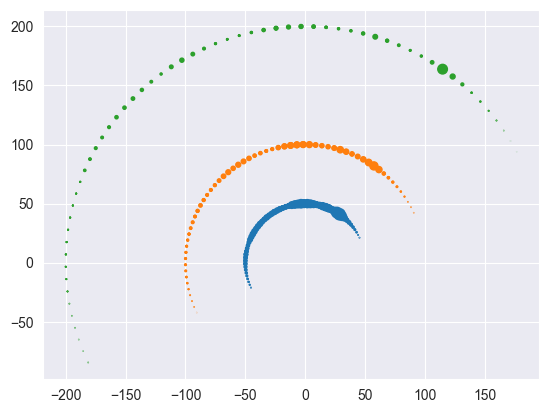

In [198]:
distances = (50, 100, 200)

for i, distance in enumerate(distances):
    scatter_concentration_plot(data1, distance)

H:\DataAnalytics\venv\lib\site-packages\matplotlib\collections.py:999: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
H:\DataAnalytics\venv\lib\site-packages\matplotlib\collections.py:999: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
H:\DataAnalytics\venv\lib\site-packages\matplotlib\collections.py:999: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


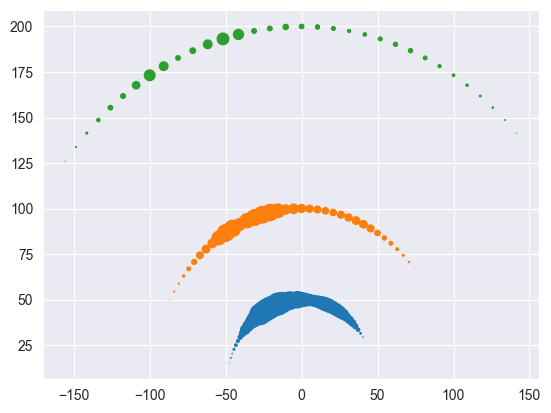

In [199]:
for i, distance in enumerate(distances):
    scatter_concentration_plot(data2, distance)

Nel punto (0,0) è situata la sorgente di SO2, mentre ad ogni punto corrisponde una misurazione del sensore con la relativa misurazione di concentrazione.

# Valori NaN

In [200]:
data1.isna().sum()

post                0
degrees             0
azimuth             0
wind_direction    525
timestamp           0
run                 0
concentration     797
distance            0
U                   0
Se                  0
Sa                  0
U1.5                0
U3.0                0
U6.0                0
U12.0               0
T1.5                0
T3.0                0
T6.0                0
T12.0               0
q                   0
correction_50       0
correction_100      0
correction_200      0
dtype: int64

In [201]:
data2.isna().sum()

post                         0
degrees                      0
azimuth                      0
wind_direction             999
timestamp                    0
run                          0
concentration             1112
distance                     0
U                            0
Sa                           0
U1.5                         0
U3.0                         0
U6.0                         0
U12.0                        0
T1.5                         0
T3.0                         0
T6.0                         0
T12.0                        0
source_strength_10min        0
source_strength_3min         0
source_strength_1.5min       0
correction_10min             0
correction_3min              0
correction_1.5min            0
dtype: int64

Il dataset contiene una gran parte di valori NaN, in particolare nelle misure di concentrazione e direzione del vento. In questi casi il sensore non ha misurato alcuna concentrazione, o non ha rilevato una distribuzione rilevante, possiamo quindi procedere a rimuoverli senza perdere valore informativo.

In [202]:
data1_fixed = data1.copy(deep=True)
data2_fixed = data2.copy(deep=True)

data1_fixed = data1_fixed[data1_fixed['concentration'] > 0]
data1_fixed = data1_fixed[data1_fixed['wind_direction'] > 0]

data2_fixed = data2_fixed[data2_fixed['concentration'] > 0]
data2_fixed = data2_fixed[data2_fixed['wind_direction'] > 0]

In [203]:
print(
    f'''
    Initial rows: {data1.shape[0]}
    Dropped rows: {data1.shape[0] - data1_fixed.shape[0]}
    Final rows: {data1_fixed.shape[0]}
    '''
)


    Initial rows: 2709
    Dropped rows: 964
    Final rows: 1745
    


In [204]:
print(
    f'''
    Initial rows: {data2.shape[0]}
    Dropped rows: {data2.shape[0] - data2_fixed.shape[0]}
    Final rows: {data2_fixed.shape[0]}
    '''
)


    Initial rows: 1701
    Dropped rows: 1146
    Final rows: 555
    


# Correzioni
Per migliorare la correttezza dei dati è possibile applicare i fattori moltiplicativi

In [187]:
data1_corrected = data1_fixed.copy(deep=True)
for i, r in data1_corrected.iterrows():
    if r['distance'] == 50:
        r['concentration'] = r['concentration'] * r['correction_50']
    elif r['distance'] == 100:
        r['concentration'] = r['concentration'] * r['correction_100']
    elif r['distance'] == 200:
        r['concentration'] = r['concentration'] * r['correction_200']
    data1_corrected.loc[i] = r

data2_corrected = data2_fixed.copy(deep=True)
for i, r in data2_corrected.iterrows():
    r['concentration'] = r['concentration'] * r['correction_10min']
    data2_corrected.loc[i] = r

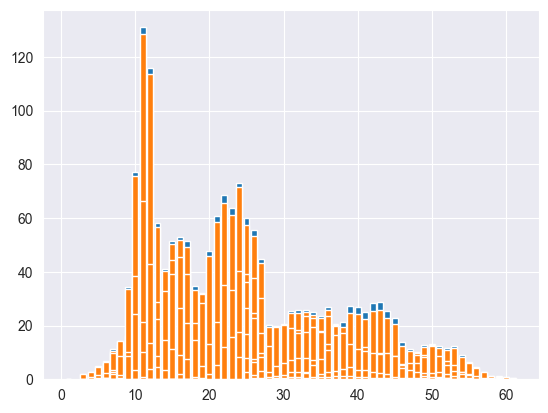

In [196]:
plt.bar(data1_fixed['post'], data1_fixed['concentration'])
plt.bar(data1_corrected['post'], data1_corrected['concentration'])
plt.show()

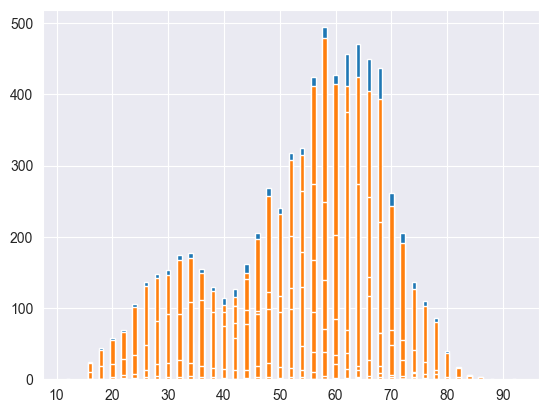

In [197]:
plt.bar(data2_fixed['post'], data2_fixed['concentration'])
plt.bar(data2_corrected['post'], data2_corrected['concentration'])
plt.show()

In [216]:
import pandas as pd

columns = ['post', 'azimuth', 'wind_direction', 'concentration', 'distance', 'U']
data1_model = data1_corrected[columns]
data2_model = data2_corrected[columns]

data_model = pd.concat([data1_model, data2_model], axis='index')

data_model

,post,azimuth,wind_direction,concentration,distance,U
11,10,52.0,0.42,0.01380,200,2.17
21,14,64.0,0.42,0.03255,50,2.17
23,14,64.0,0.42,0.00460,200,2.17
24,15,67.0,0.42,0.03720,50,2.17
26,15,67.0,0.42,0.01380,200,2.17
...,...,...,...,...,...,...
1671,70,126.0,1.25,3.28060,50,4.07
1672,70,126.0,1.25,0.90428,100,4.07
1677,72,129.0,0.42,0.18800,50,4.07
1678,72,129.0,0.42,0.01692,100,4.07


array([[<Axes: title={'center': 'post'}>,
        <Axes: title={'center': 'azimuth'}>],
       [<Axes: title={'center': 'wind_direction'}>,
        <Axes: title={'center': 'concentration'}>],
       [<Axes: title={'center': 'distance'}>,
        <Axes: title={'center': 'U'}>]], dtype=object)

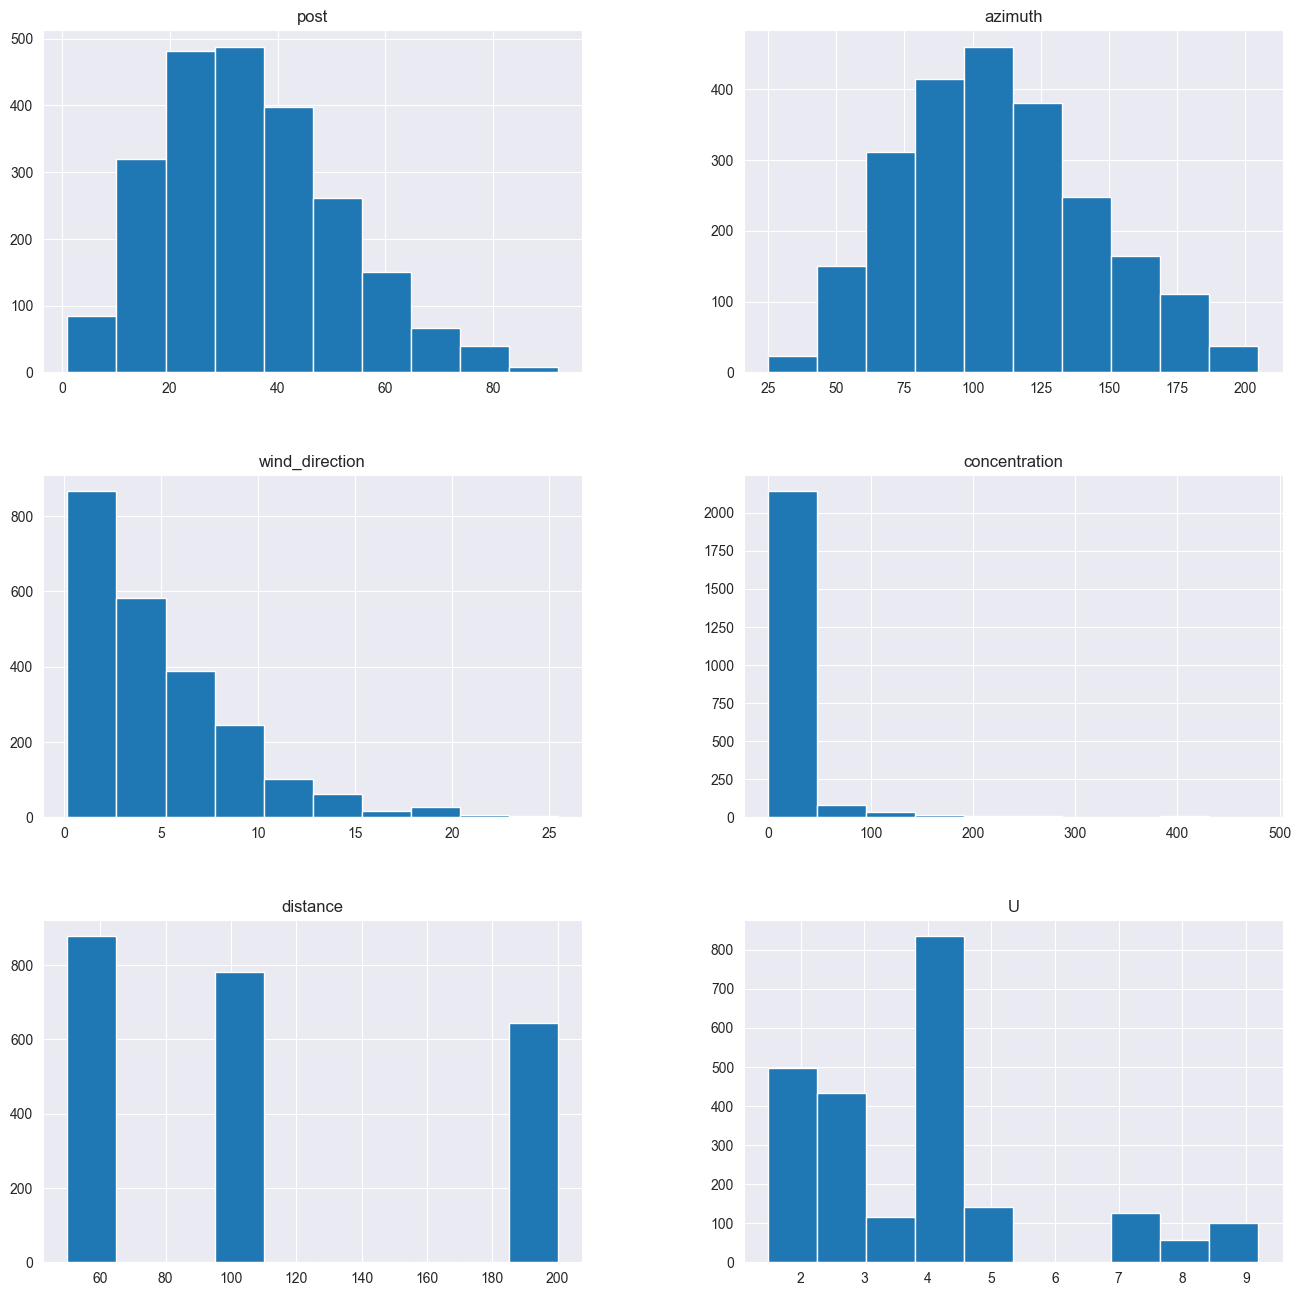

In [217]:
data_model.hist(figsize=(16, 16))

In [218]:
save_to_csv(data_model, 'data.csv')